# Import Libraries

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering,
    SpectralClustering,
    Birch,
    DBSCAN,
)
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

# Preprocessing 

In [46]:
# Load Data
def load_data(train_path):
    train_data = pd.read_csv(train_path)
    X_train = train_data.drop(columns=["Sequence Name"], errors='ignore')
    return X_train

# Preprocess Data
def preprocess_data(X_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    return pd.DataFrame(X_train_scaled, columns=X_train.columns), scaler  # Convert to DataFrame

# Load and preprocess
train_path = "yeast_train.csv"
X_train = load_data(train_path)
X_train_scaled, scaler = preprocess_data(X_train)

In [58]:
# Summary Statistics
print("\n📊 Summary Statistics (Scaled Data):")
print(X_train_scaled.describe().T.round(2))


📊 Summary Statistics (Scaled Data):
      count  mean  std   min   25%   50%   75%    max
mcg  1187.0   0.0  1.0 -2.82 -0.72 -0.14  0.51   3.63
gvh  1187.0   0.0  1.0 -2.96 -0.64 -0.07  0.57   4.02
alm  1187.0  -0.0  1.0 -3.36 -0.58  0.12  0.70   5.80
mit  1187.0  -0.0  1.0 -1.92 -0.66 -0.29  0.45   5.50
erl  1187.0  -0.0  1.0 -0.10 -0.10 -0.10 -0.10   9.90
pox  1187.0  -0.0  1.0 -0.11 -0.11 -0.11 -0.11  10.13
vac  1187.0   0.0  1.0 -8.45 -0.33  0.17  0.51   3.89
nuc  1187.0  -0.0  1.0 -2.62 -0.53 -0.53  0.23   6.86


<Figure size 1200x600 with 0 Axes>

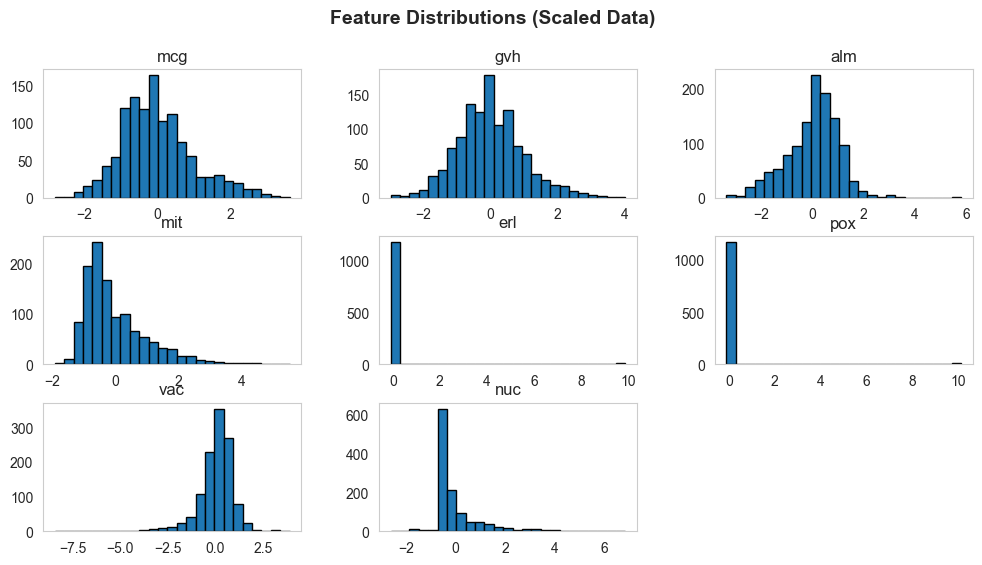

In [66]:
# Histogram for Feature Distributions
plt.figure(figsize=(12, 6))
X_train_scaled.hist(figsize=(12, 6), bins=25, edgecolor="black", grid=False)
plt.suptitle("Feature Distributions (Scaled Data)", fontsize=14, fontweight="bold")
plt.show()

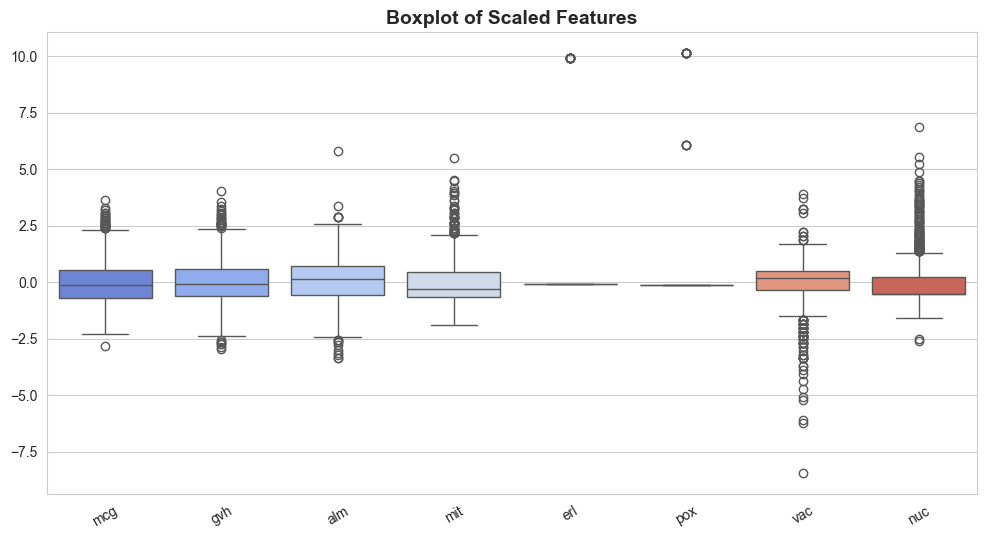

In [64]:
# Boxplots to Identify Outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train_scaled, palette="coolwarm")
plt.title("Boxplot of Scaled Features", fontsize=14, fontweight="bold")
plt.xticks(rotation=30)
plt.show()

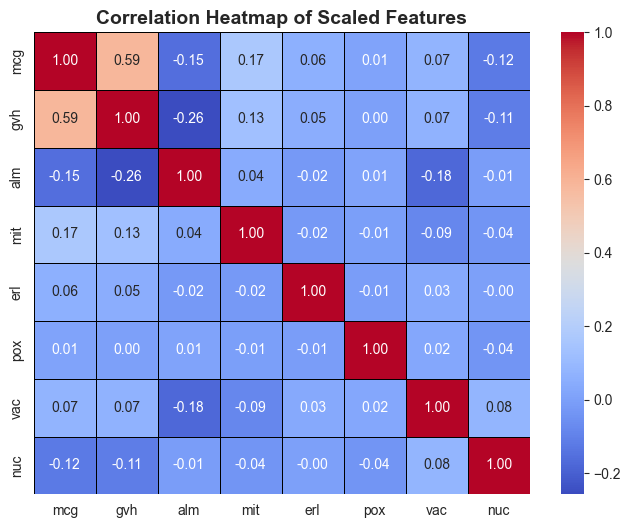

In [70]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(X_train_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, linecolor="black")
plt.title("Correlation Heatmap of Scaled Features", fontsize=14, fontweight="bold")
plt.show()

# Finding Optimal Number of Clusters

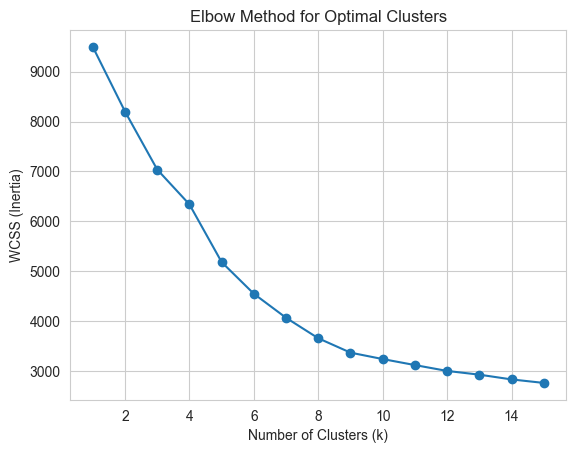

In [79]:
def find_optimal_clusters_elbow(X, max_clusters=15):
    wcss = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)  # Inertia is the WCSS

    plt.plot(range(1, max_clusters + 1), wcss, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS (Inertia)')
    plt.title('Elbow Method for Optimal Clusters')
    plt.show()

find_optimal_clusters_elbow(X_train_scaled)

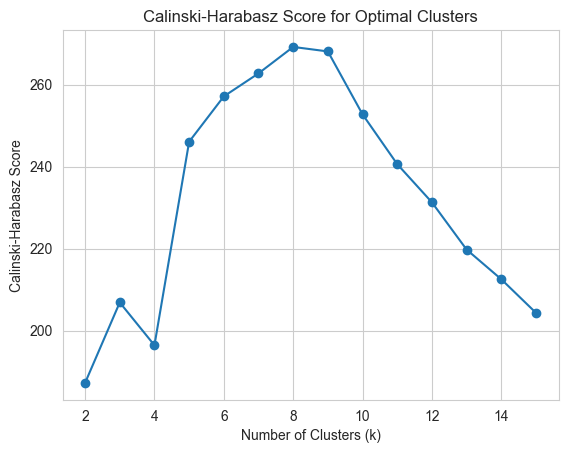

In [81]:
def find_optimal_clusters_calinski_harabasz(X, max_clusters=15):
    ch_scores = []
    for k in range(2, max_clusters + 1):  # CH score is not defined for k=1
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        ch_scores.append(calinski_harabasz_score(X, labels))

    plt.plot(range(2, max_clusters + 1), ch_scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Calinski-Harabasz Score')
    plt.title('Calinski-Harabasz Score for Optimal Clusters')
    plt.show()

find_optimal_clusters_calinski_harabasz(X_train_scaled)

# Clustering Analysis for multiple models

In [98]:
def compute_clustering_scores(X, labels):
    unique_labels = set(labels)
    if len(unique_labels) < 2:
        return np.nan, np.nan, np.nan
    return (
        silhouette_score(X, labels),
        calinski_harabasz_score(X, labels),
        davies_bouldin_score(X, labels)
    )

def clustering_analysis(X):
    clustering_algorithms = {
        "KMeans": KMeans(n_clusters=8, random_state=42, n_init=10),
        "Agglomerative-Single": AgglomerativeClustering(n_clusters=8, linkage='single'),
        "Agglomerative-Average": AgglomerativeClustering(n_clusters=8, linkage='average'),
        "Agglomerative-Complete": AgglomerativeClustering(n_clusters=8, linkage='complete'),
        "BIRCH": Birch(n_clusters=8),
        "Gaussian Mixture": GaussianMixture(n_components=8, random_state=42),
        "DBSCAN": DBSCAN(eps=0.5, min_samples=5)
    }
    
    # Print header
    print(f"{'Method':<25}{'Silhouette Score':<20}{'Calinski-Harabasz Score':<25}{'Davies-Bouldin Score'}")
    print("=" * 80)
    
    for method, model in clustering_algorithms.items():
        labels = model.fit_predict(X)
        sil_score, ch_score, db_score = compute_clustering_scores(X, labels)
        print(f"{method:<25}{sil_score:<20.4f}{ch_score:<25.4f}{db_score:.4f}")

clustering_analysis(X_train_scaled)

Method                   Silhouette Score    Calinski-Harabasz Score  Davies-Bouldin Score
KMeans                   0.2235              269.1713                 1.1175
Agglomerative-Single     0.4838              65.9631                  0.5655
Agglomerative-Average    0.3439              72.5807                  0.6115
Agglomerative-Complete   0.2132              144.4589                 1.1414
BIRCH                    0.1771              222.2297                 1.2425
Gaussian Mixture         -0.0383             112.4926                 2.4976
DBSCAN                   -0.3718             1.9526                   2.2676


In [102]:
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
kmeans.fit(X_train_scaled)
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

silhouette = silhouette_score(X_train_scaled, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(X_train_scaled, kmeans.labels_)
davies_bouldin = davies_bouldin_score(X_train_scaled, kmeans.labels_)

print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz:.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")

Silhouette Score: 0.2235
Calinski-Harabasz Score: 269.1713
Davies-Bouldin Score: 1.1175
